In [34]:
import os
import math
import random
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary

from data_pipeline import SignsDataset
from training import train, plot_loss_curves
from prediction import predict_test_loader, pred_and_plot_image

In [35]:
# Check if a CUDA-compatible GPU is available.
# If available, set the 'device' variable to 'cuda'; otherwise, set it to 'cpu'.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### A short examination of the data

In [36]:
# Reading the csv files containing the informations about the datasets
meta_df = pd.read_csv('data/Meta.csv')
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')

# Define the paths to the folders where the actual images can be found
data_path = "data"

In [37]:
# How many images we have in the train, test, meta datasets
print(meta_df.shape)
print(train_df.shape)
print(test_df.shape)

(43, 5)
(39209, 8)
(12630, 8)


In [38]:
# How many different classes we have in each dataframe
print(len(meta_df['ClassId'].unique()))
print(len(train_df['ClassId'].unique()))
print(len(test_df['ClassId'].unique()))

43
43
43


In [39]:
# Let's take a look on the structure of the previously read dataframes
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [40]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [41]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


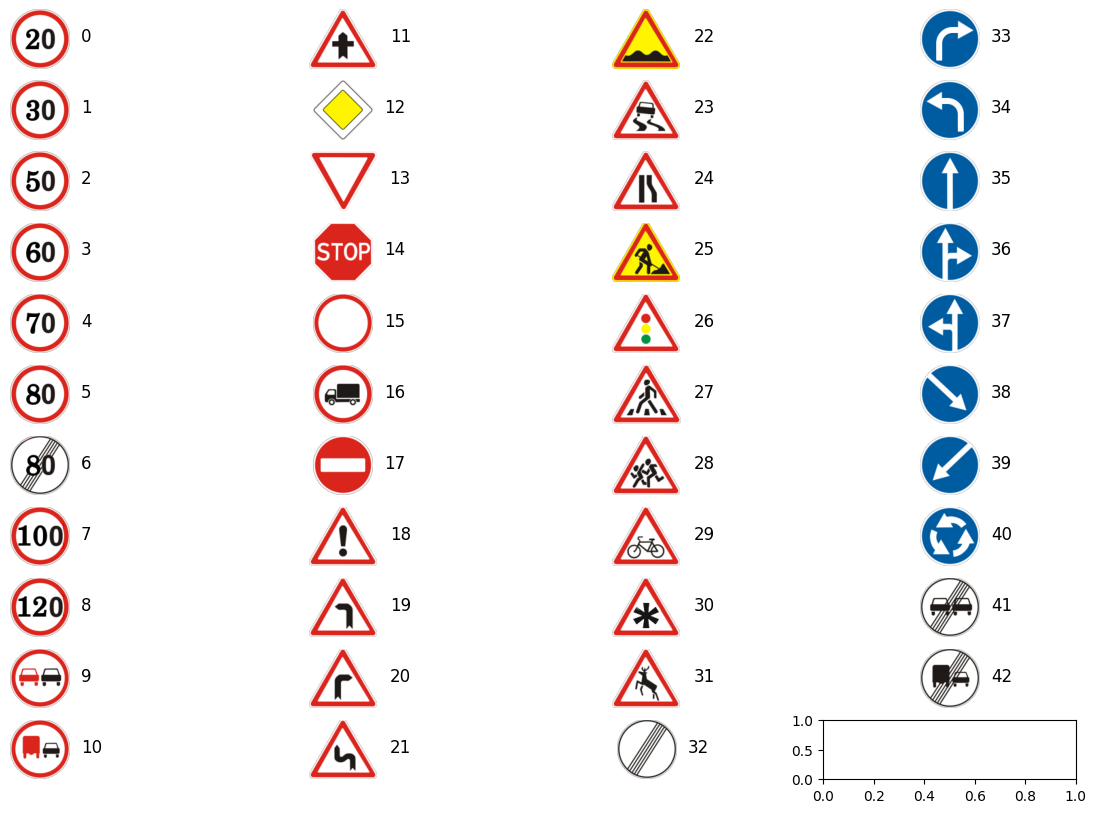

In [42]:
def plot_meta_data(df):

    """ 
    Visualize the possbile classes with their labels, from the meta data folder. 

    """

    df.sort_values(by='ClassId', inplace=True)

    col_num = 4
    row_num = math.ceil(df.shape[0] / col_num)

    fig, axes = plt.subplots(row_num, col_num, figsize=(15, 10))

    for i, image_path in enumerate(range(meta_df.shape[0])):

        image_path = os.path.join(data_path,meta_df.Path.iloc[i])
        image = Image.open(image_path)

        row = i % row_num
        col = i // row_num

        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(
            label= meta_df.ClassId.iloc[i],
            loc="right", 
            y=.4,
            x=1.2,
            rotation=0, 
            ha="left", 
            va="center",
    )

plot_meta_data(df=meta_df)

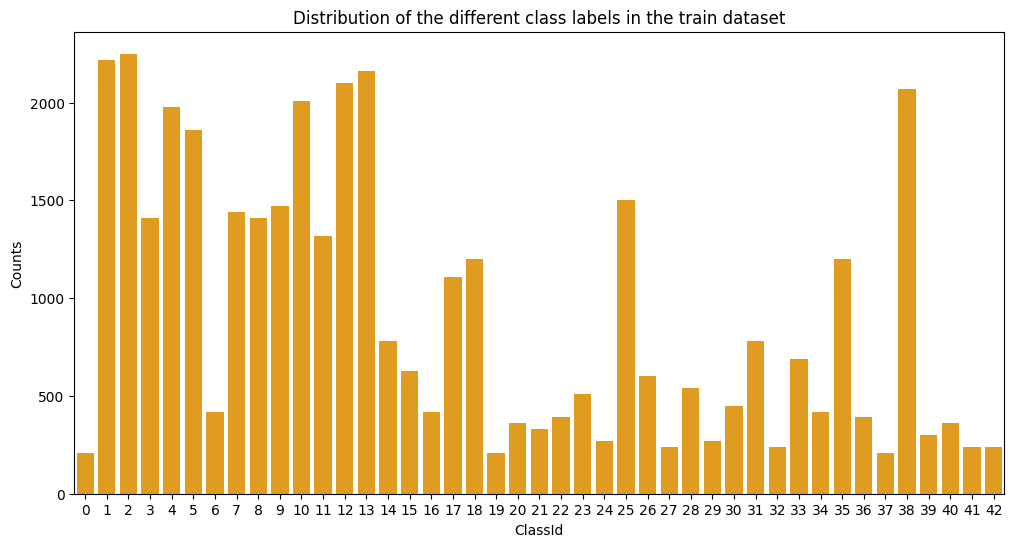

In [43]:
# Checking the distribution of the different class labels in the train dataset
classes = train_df["ClassId"].value_counts()
plt.figure(figsize=(12,6))
plt.title("Distribution of the different class labels in the train dataset")
plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(y=classes.values, x=classes.index, color='orange');

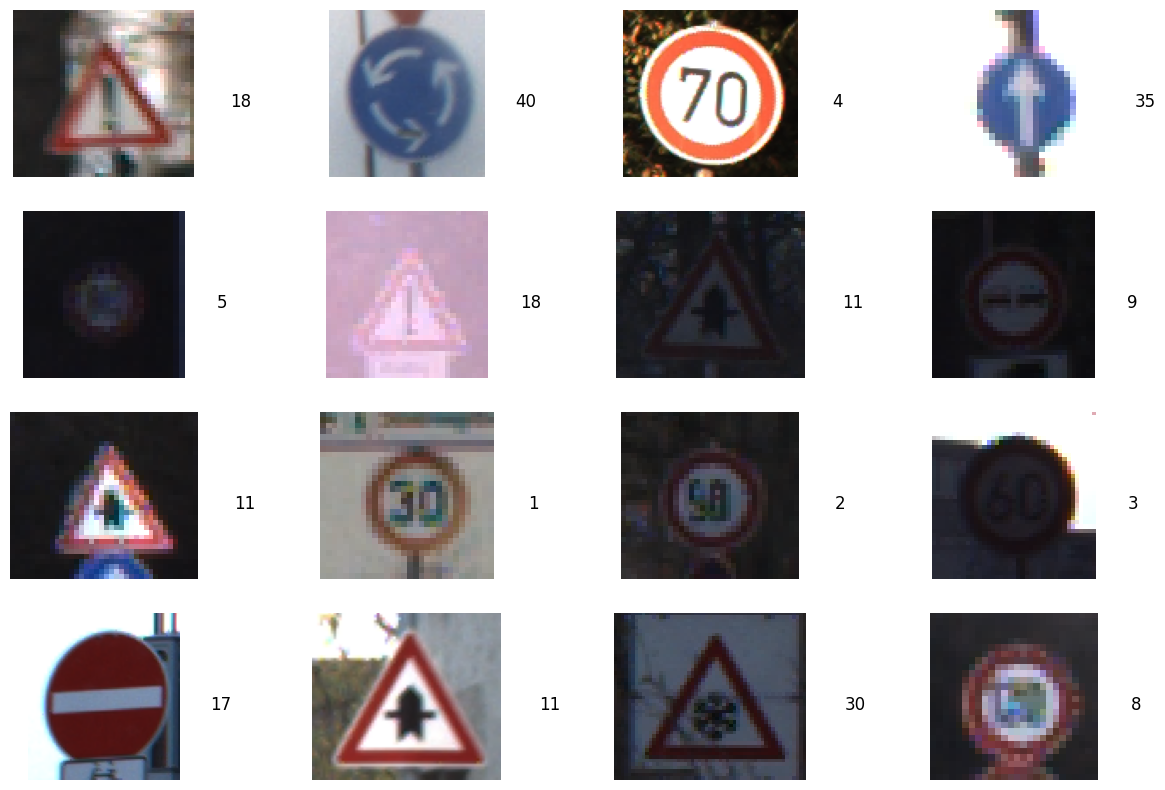

In [44]:
def display_random_images(df: pd.DataFrame,
                          n: int = 16,
                          seed: int = None):

    """ 
    Visualize some random images (with labels) based on the given dataframe
    """
    
    if seed:
        random.seed(seed)


    row_num = math.ceil(n / 4)
    fig, axes = plt.subplots(row_num, 4, figsize=(15, 10))

    sample_df = df.sample(n)
    for i, item in enumerate(sample_df.values):
        image = Image.open(os.path.join(data_path,item[7]))

        row = i % row_num
        col = i // row_num
        
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(
            label= item[6],
            loc="right", 
            y=.4,
            x=1.2,
            rotation=0, 
            ha="left", 
            va="center",
    )


display_random_images(train_df)

### Creating the data pipeline

In [45]:
# Define a series of transformations to be applied to the images
data_transforms = transforms.Compose([
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.Resize((64,64))
])

# Create a dataset instances using the SignsDataset class
training_set = SignsDataset(
    df=train_df,
    source_dir=data_path,
    transform=data_transforms
)

test_set = SignsDataset(
    df=test_df,
    source_dir=data_path,
    transform=data_transforms
)

In [46]:
# Loading the SignsDataset instances into DataLoaders
train_loader = DataLoader(
    dataset=training_set, 
    batch_size=32, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_set, 
    batch_size=1, 
    shuffle=False
)

print(f'training size:{len(train_loader.dataset)}')
print(f'test size:{len(test_loader.dataset)}')


training size:39209
test size:12630


### Model Initialization and Training

In this part I will initialize and train the following models:

1. ResNet50 without pre-trained weights  
2. Resnet50 with pre-trained weights (IMAGENET1K_V1)  
3. Resnet50 with pre-trained weights (IMAGENET1K_V2)

In [47]:
# Set random seeds
torch.manual_seed(1234) 
torch.cuda.manual_seed(1234)

In [48]:
# Load the ResNet-50 model
model1 = resnet50(weights=None)

# modify the output layer 
num_classes = 43
model1.fc = nn.Linear(2048, num_classes)

In [49]:
# Let's get a deeper insight into the ResNet50's architecture
sample_input_data = torch.randn(1,3,64,64)
summary(model=model1,input_data= sample_input_data)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 43]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 256, 16, 16]          --
│    └─Bottleneck: 2-1                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --
│ 

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.001)
epochs = 15

model1_results = train(
        model=model1.to(device), 
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        optimizer=optimizer,
        loss_fn=loss_fn, 
        epochs=epochs,
        saving=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/oli/python/data-analysis/venv-data-analysis/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 | train_loss: 1.2007 | train_acc: 0.6695 | test_loss: 0.3618 | test_acc: 0.8972
Epoch: 2 | train_loss: 0.1143 | train_acc: 0.9656 | test_loss: 0.2560 | test_acc: 0.9342
Epoch: 3 | train_loss: 0.0796 | train_acc: 0.9773 | test_loss: 0.2603 | test_acc: 0.9354
Epoch: 4 | train_loss: 0.0581 | train_acc: 0.9831 | test_loss: 0.3962 | test_acc: 0.9231
Epoch: 5 | train_loss: 0.0501 | train_acc: 0.9861 | test_loss: 0.2425 | test_acc: 0.9413
Epoch: 6 | train_loss: 0.0360 | train_acc: 0.9896 | test_loss: 0.2309 | test_acc: 0.9441
Epoch: 7 | train_loss: 0.0447 | train_acc: 0.9895 | test_loss: 0.2561 | test_acc: 0.9440
Epoch: 8 | train_loss: 0.0303 | train_acc: 0.9914 | test_loss: 0.1903 | test_acc: 0.9534
Epoch: 9 | train_loss: 0.0227 | train_acc: 0.9938 | test_loss: 0.3852 | test_acc: 0.9323
Epoch: 10 | train_loss: 0.0225 | train_acc: 0.9938 | test_loss: 0.1716 | test_acc: 0.9543
Epoch: 11 | train_loss: 0.0210 | train_acc: 0.9945 | test_loss: 0.1805 | test_acc: 0.9592
Epoch: 12 | train_l

In [51]:
# Load the pre-trained ResNet-50 model with the IMAGENET1K_V1 weights
model2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the output layer 
num_classes = 43
model2.fc = nn.Linear(2048, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.001)
epochs = 15

model2_results = train(
        model=model2.to(device), 
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        optimizer=optimizer,
        loss_fn=loss_fn, 
        epochs=epochs,
        saving=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2980 | train_acc: 0.9164 | test_loss: 0.1508 | test_acc: 0.9614
Epoch: 2 | train_loss: 0.0565 | train_acc: 0.9856 | test_loss: 0.2553 | test_acc: 0.9276
Epoch: 3 | train_loss: 0.0396 | train_acc: 0.9900 | test_loss: 0.0941 | test_acc: 0.9751
Epoch: 4 | train_loss: 0.0303 | train_acc: 0.9917 | test_loss: 0.1048 | test_acc: 0.9729
Epoch: 5 | train_loss: 0.0243 | train_acc: 0.9936 | test_loss: 0.3145 | test_acc: 0.9537
Epoch: 6 | train_loss: 0.0422 | train_acc: 0.9901 | test_loss: 0.1381 | test_acc: 0.9641
Epoch: 7 | train_loss: 0.0201 | train_acc: 0.9941 | test_loss: 0.0877 | test_acc: 0.9779
Epoch: 8 | train_loss: 0.0123 | train_acc: 0.9969 | test_loss: 0.1707 | test_acc: 0.9641
Epoch: 9 | train_loss: 0.0211 | train_acc: 0.9949 | test_loss: 0.0962 | test_acc: 0.9736
Epoch: 10 | train_loss: 0.0133 | train_acc: 0.9967 | test_loss: 0.1416 | test_acc: 0.9663
Epoch: 11 | train_loss: 0.0166 | train_acc: 0.9957 | test_loss: 0.1266 | test_acc: 0.9702
Epoch: 12 | train_l

In [52]:
# Load the pre-trained ResNet-50 model with the IMAGENET1K_V2 weights
model3 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Modify the output layer 
num_classes = 43
model3.fc = nn.Linear(2048, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model3.parameters(), lr=0.001)
epochs = 15

model3_results = train(
        model=model3.to(device), 
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        optimizer=optimizer,
        loss_fn=loss_fn, 
        epochs=epochs,
        saving=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1688 | train_acc: 0.9548 | test_loss: 0.1210 | test_acc: 0.9684
Epoch: 2 | train_loss: 0.0440 | train_acc: 0.9889 | test_loss: 0.1276 | test_acc: 0.9658
Epoch: 3 | train_loss: 0.0371 | train_acc: 0.9907 | test_loss: 0.1298 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.0269 | train_acc: 0.9934 | test_loss: 0.2405 | test_acc: 0.9405
Epoch: 5 | train_loss: 0.0262 | train_acc: 0.9939 | test_loss: 0.0830 | test_acc: 0.9787
Epoch: 6 | train_loss: 0.0229 | train_acc: 0.9946 | test_loss: 0.0824 | test_acc: 0.9805
Epoch: 7 | train_loss: 0.0226 | train_acc: 0.9951 | test_loss: 0.2367 | test_acc: 0.9491
Epoch: 8 | train_loss: 0.0220 | train_acc: 0.9949 | test_loss: 0.1266 | test_acc: 0.9683
Epoch: 9 | train_loss: 0.0112 | train_acc: 0.9977 | test_loss: 0.0797 | test_acc: 0.9790
Epoch: 10 | train_loss: 0.0098 | train_acc: 0.9973 | test_loss: 0.1706 | test_acc: 0.9623
Epoch: 11 | train_loss: 0.0336 | train_acc: 0.9936 | test_loss: 0.0771 | test_acc: 0.9821
Epoch: 12 | train_l

### Doing some test predictions

In [59]:
# Load the ResNet-50 model without any pre-trained weights
model_final = resnet50(weights=None)

# Modify the output layer 
num_classes = 43
model_final.fc = nn.Linear(2048, num_classes)

# Loading the parameters with the best performance
model_final.load_state_dict(torch.load('saved_models/Model-20230925_165806.pth'))


<All keys matched successfully>

In [60]:
# Run the model to make predictions on the test data
act, pred = predict_test_loader(model=model_final.to(device), dataloader=test_loader)

# Create a new df containing the the test data with its predictions
test_with_pred_df = test_df.copy()
test_with_pred_df['predicted'] = pred

Let's take a look on the model's prediction on the test data

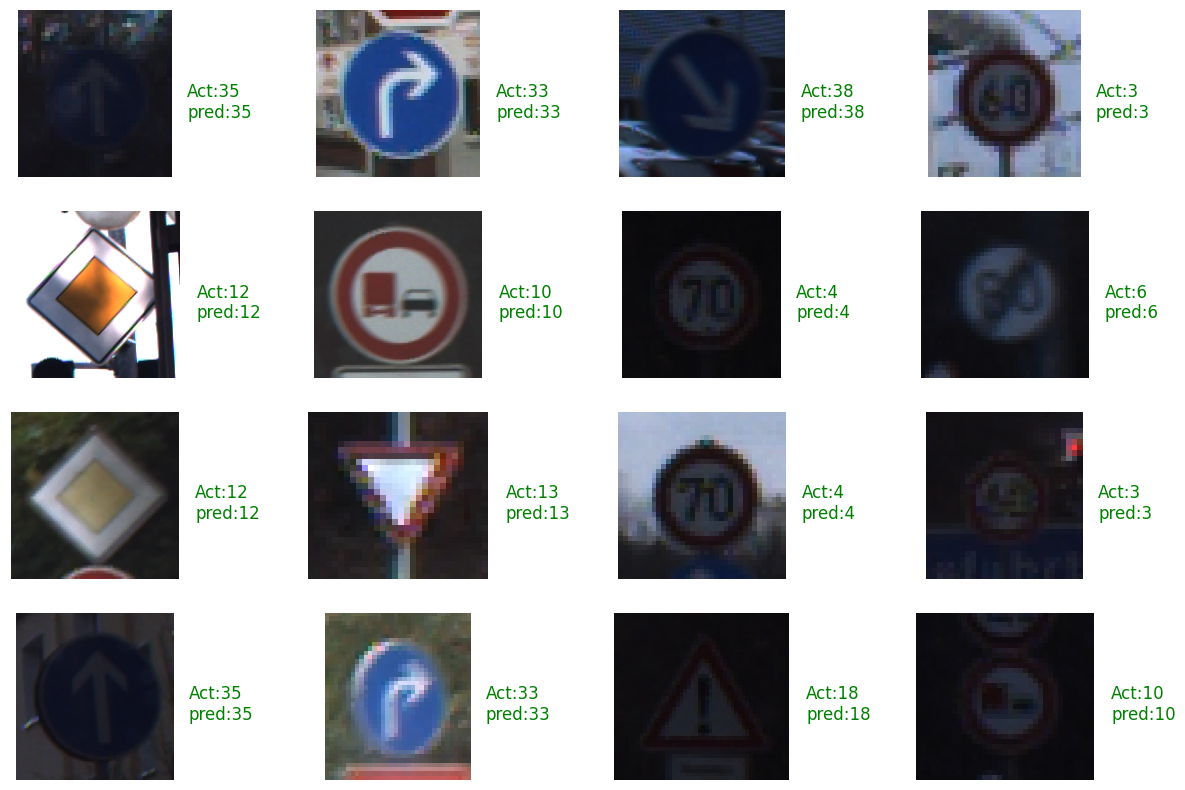

In [67]:
def display_predictions(df: pd.DataFrame,
                          n: int = 16,
                          seed: int = None):
    
    if seed:
        random.seed(seed)


    row_num = math.ceil(n / 4)
    fig, axes = plt.subplots(row_num, 4, figsize=(15, 10))

    sample_df = df.sample(n)
    for i, item in enumerate(sample_df.values):
        image = Image.open(os.path.join(data_path,item[7]))

        row = i % row_num
        col = i // row_num
        
        axes[row, col].imshow(image)
        axes[row, col].axis('off')

        if item[6] != item[8]:
            color = 'r'
        else:
            color = 'g'

        axes[row, col].set_title(
            label= f'Act:{item[6]}\npred:{item[8]}',
            loc="right", 
            y=.4,
            x=1.1,
            rotation=0, 
            ha="left", 
            va="center",
            color=color
    )


display_predictions(test_with_pred_df)

I've collected a couple of picture from google street view. Let's see how our model performs on them 

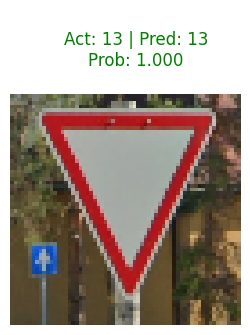

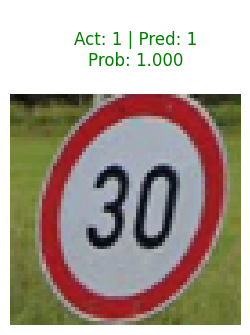

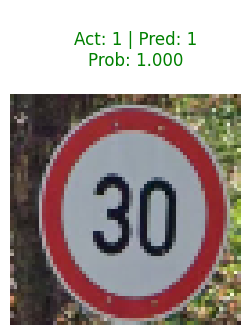

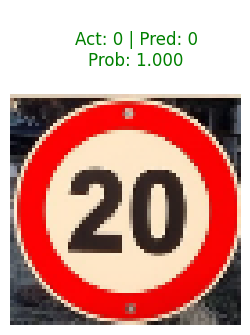

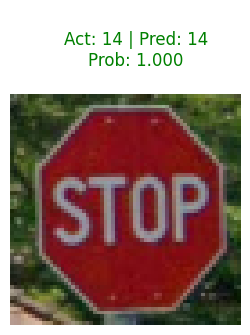

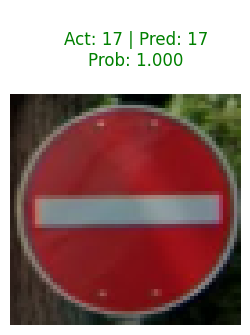

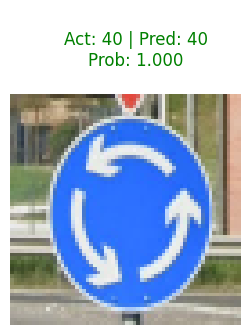

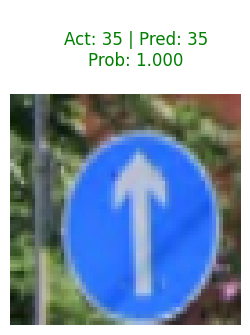

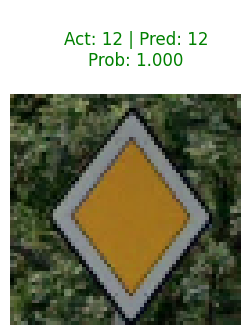

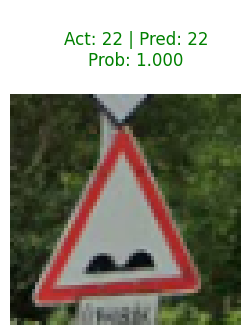

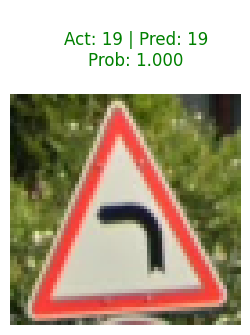

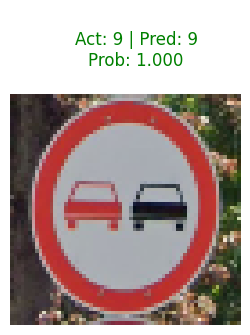

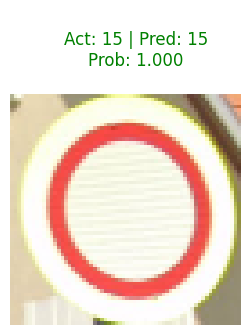

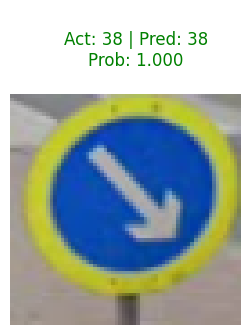

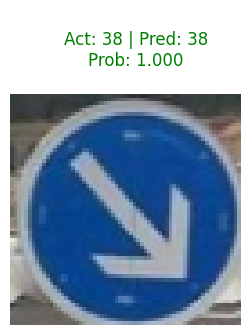

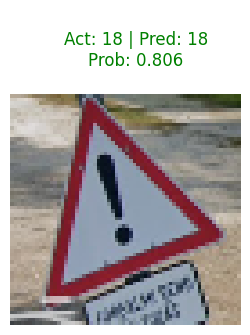

In [70]:
data_transforms_for_png = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3]), #The pictures are in png format, therefore I need to eliminate the 4th channel. 
    transforms.Resize((64,64)),
])

custom_files = []
for dirpath, dirnames, filenames in os.walk('custom-test'):
    for filename in filenames:
        custom_files.append(os.path.join(dirpath,filename))

# Pred on our custom image
for path in custom_files:
    pred_and_plot_image(model=model_final,
                        image_path=path,
                        transform=data_transforms_for_png,
                        act_class=path.split("/")[1],
                        device=device)